<a href="https://colab.research.google.com/github/itskutush/Attention-based-automated-radiology-report-generation/blob/main/Attention_based_radiology_report_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check GPU
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Confirm T4 GPU
!nvidia-smi


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sun Sep 21 13:18:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |              

In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

# Dataset Import

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xrays-indiana-university' dataset.
Path to dataset files: /kaggle/input/chest-xrays-indiana-university


In [6]:
image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
images = glob(image_path + "*.png")
len(images)

7470

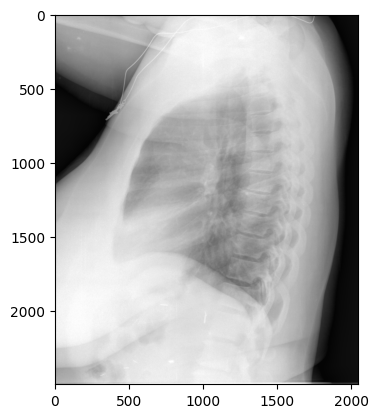

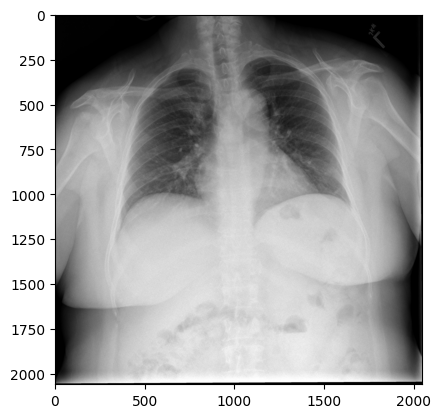

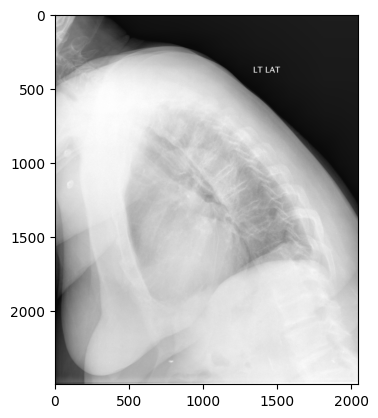

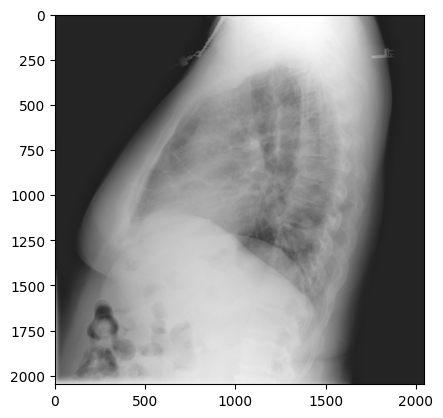

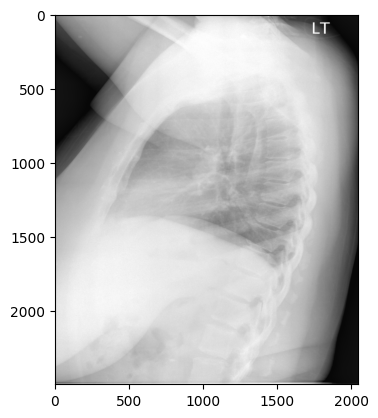

In [7]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [8]:
import re
# Read in the projections data
projections = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

# Read in the reports data
reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Define the path to the images folder
images_folder = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Merge the projections and reports data on the UID column
reports = pd.merge(projections, reports, on='uid')

# Create a dictionary of image filenames and their corresponding captions
data = {}
for i in range(len(reports)):
    filename = reports.loc[i, 'filename']
    caption = reports.loc[i, 'impression']
    if filename not in data:
        data[filename] = []
    if isinstance(caption, str) and re.match(r'^\d+\.', caption):
        data[filename].append(caption.split('. ')[1])
    else:
        if data[filename]:
            data[filename][-1] += " " + caption
        else:
            data[filename].append(caption)